In [1]:
import os
import mlflow

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

In [ ]:
df = pd.read_pickle('data/clean_data.pkl').sample(frac=0.1, random_state = 2) # Уменьшаем размер чтобы модель быстрее обучалась на лекции
df.info()

In [3]:
df = df.rename(columns={'price': 'target'})
df = df.drop(columns=['date', 'time'])

In [ ]:
df

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=2)

In [ ]:
cat_features = X_train.select_dtypes(include=['category','object']).columns.to_list()
cat_features

In [ ]:
num_features = X_train.select_dtypes(include=['number']).columns.to_list()
num_features

https://scikit-learn.org/stable/api/sklearn.preprocessing.html - разные способы кодирования и скалирования

In [8]:
s_scaler = StandardScaler()
l_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999999) # unknown_value нужно выбирать с умом
regressor = CatBoostRegressor()

## Column transformer

In [9]:
# Для удобной работы со столбцами
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования

In [ ]:

pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor)])

pipeline.fit(X_train, y_train)


In [ ]:
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

In [12]:

# Работаем с MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri)   



In [13]:
# название тестового эксперимента, запуска (run) внутри него, имени, под которым модель будет регистрироваться
EXPERIMENT_NAME = "estate_project"
RUN_NAME = "baseline model"
REGISTRY_MODEL_NAME = "estate_model_rf"

# Логируем вручную

In [ ]:
# Обязательно логируем сигнатуру модели и пример входных данных. Подготовим их
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)

In [15]:
# Будем логировать requirements и артефакт - текстовый файл
req_file = 'requirements.txt'
art = 'comment.txt'

In [16]:
# Параметры, котороые будут залогированы, можем задавать вручную или полностью взять из модели
#params_dict = {'n_estimators': 10, 'max_depth': 10}
params_dict = pipeline.get_params()

In [ ]:
# Когда создаем новый эксперимент, то: 
experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

# Впоследствии. чтобы добавлять запуски в этот же эксепримент мы должны получить его id:
#experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

# Удаление runs, experiments

Использовать осторожно

In [18]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
#mlflow.delete_experiment(experiment_id)

In [ ]:
mlflow.search_runs(
    #experiment_ids=[experiment_id],
    experiment_names=[EXPERIMENT_NAME],
    # filter_string='status = "FAILED"'
    #filter_string='metrics.mae > 1'
    
)

In [20]:

#mlflow.delete_run('74d2a7a40c07413c9cf65df841164356')

# Автологирование
После включения будет срабатывать на каждом обучении модели (на методе fit()).

Есть плюсы, есть и минусы. Предлагается сделать прогон и сравнить с результатами вручную 

In [ ]:
mlflow.sklearn.autolog()

with mlflow.start_run(run_name='auto', experiment_id=experiment_id) as run:
    pipeline.fit(X_train, y_train)


In [22]:
# Отключаем автологирование
mlflow.sklearn.autolog(disable=True)

# Model #2
Обучим вторую "маленькую" модель


In [23]:
regressor2 = RandomForestRegressor(n_estimators=10, max_depth=6)

In [ ]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor2)])

pipeline.fit(X_train, y_train)

In [ ]:
predictions = pipeline.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

In [ ]:
# !!! Проверить название прогона а также все логируемые параметры и артефакты, что они соответствуют второй "маленькой" модели. 


RUN_NAME = 'smaller_model'

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

In [ ]:
# No model
# Логировать можно только артефакты, без модели. Например, залогироавть графики после этапа EDA

RUN_NAME = 'no_model'
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id 
    mlflow.log_artifact(art)


run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')


In [ ]:
run_id = '06fa7ec1f1b74aedb3509c88dc4ee1c0' # Указываем run id
mlflow.register_model(f"runs:/{run_id}/models", REGISTRY_MODEL_NAME)

In [ ]:
# Можно регистрировать сразу при создании прогона

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name='register_at_run', experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file,
                             registered_model_name = REGISTRY_MODEL_NAME # Указываем для какой модели регистрируем
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

In [ ]:
# Можно найти зарегистрированные модели
model_reg = mlflow.search_registered_models()
model_reg[0]

In [32]:

model_name = REGISTRY_MODEL_NAME
model_version = 1

model_loaded = mlflow.sklearn.load_model(model_uri=f"models:/{model_name}/{model_version}")


In [ ]:
model_loaded.predict(X_test.iloc[0:1])

In [ ]:
y_test.iloc[0]

# Feature engineering

## Sklearn

In [35]:
from sklearn.preprocessing import QuantileTransformer, SplineTransformer, PolynomialFeatures, MinMaxScaler

In [36]:
X_train_sklearn = X_train.copy()

#### PolynomialFeatures
Создает полином степени `degree` из указанных признаков


In [37]:
pf = PolynomialFeatures(degree=2)

In [ ]:
X_train_sklearn

In [ ]:
pf.fit_transform(X_train_sklearn[['area','kitchen_area']])

#### SplineTransformer
Cоздаёт новую матрицу признаков, состоящую из сплайнов порядка degree. Количество сгенерированных сплайнов равно `n_splines=n_knots + degree - 1` для каждого признака, где

`n_knots` определяет количество узлов (точек, в которых сопрягаются сплайны) для каждого признака. 

`degree` определяет порядок полинома, используемого для построения сплайнов. 

In [43]:
sp = SplineTransformer(n_knots=3, degree=3)

In [ ]:
sp.fit_transform(X_train_sklearn[['area']])

#### QuantileTransformer
Этот метод преобразует признаки, чтобы они распределялись равномерно или нормально — так данные меньше подвергаются влиянию выбросов. Преобразование применяется к каждому признаку независимо. Идея метода такова: оценить функцию распределения признака, чтобы преобразовать исходные значения в равномерное или нормальное распределение. 

`output_distribution='uniform'` или
`output_distribution='normal'` соответственно


Пример использования: если у вас есть данные о доходах с широким диапазоном значений, квантильное преобразование сделает их более сопоставимыми и устойчивыми к выбросам.

In [47]:
qt = QuantileTransformer()

In [ ]:
qt.fit_transform(X_train_sklearn[['area']])

### Объединяем в ColumnTransformer и создаем Pipeline 

In [49]:
pf = PolynomialFeatures(degree=2)
qt = QuantileTransformer()
sp = SplineTransformer(n_knots=3, degree=3)

In [50]:
# Значения преобразованных признаков нужно отскейлить, поэтому создаем pipeline из двух шагов - преобразование и скейлинг
pf_pipeline = Pipeline(steps=[
    ('poly', pf),
    ('scale', StandardScaler())
])

In [51]:
preprocessor_sklearn = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
        ('quantile', qt,num_features),
        ('poly', pf_pipeline, ['area', 'kitchen_area']), # В преобразования добавляем созданный ранее pipeline
        ('spline', sp, ['area'])
    ],
    remainder='drop',
    ) # Удаляем столбцы, которые не затронуты преобразования

### Посмотрим что из себя теперь представляет датафрейм

In [56]:
## не влезаем в float64 в полиномальном преобразовании. Использовать его нужно с умом!
X_train_sklearn[['area', 'kitchen_area']] = X_train_sklearn[['area', 'kitchen_area']].astype('float128')
X_train_sklearn[['area', 'kitchen_area']] = X_train_sklearn[['area', 'kitchen_area']].astype('float128')

In [58]:
X_train_sklearn_raw = preprocessor_sklearn.fit_transform(X_train_sklearn)
X_train_sklearn = pd.DataFrame(X_train_sklearn_raw, columns=preprocessor_sklearn.get_feature_names_out())

In [80]:
# Удобно использовать для отображения всех строк\столбцов в DataFrame
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display (X_train_sklearn)

num__geo_lat  num__geo_lon  num__level  num__levels  num__rooms  \
0           0.495902     -0.449742    0.359235    -0.214789    0.253413   
1           0.177806      1.433673   -0.246529    -0.367718    0.253413   
...              ...           ...         ...          ...         ...   
410773     -0.748366     -0.804077   -0.650371     0.702788    0.253413   
410774      1.257769     -1.101815   -0.044608     0.091070    1.175911   

        num__area  num__kitchen_area  cat__region  cat__building_type  \
0        0.063735          -0.186285         20.0                 1.0   
1       -0.114293          -0.186285         70.0                 1.0   
...           ...                ...          ...                 ...   
410773   1.365441           1.501833         52.0                 3.0   
410774   0.553789          -0.142544         14.0                 1.0   

        cat__object_type  quantile__geo_lat  quantile__geo_lon  \
0                    0.0           0.766257           0.511028   
1                    0.0           0.297142           0.867999   
...                  ...                ...                ...   
410773               0.0           0.193143           0.114753   
410774               0.0           0.908036           0.075725   

        quantile__level  quantile__levels  quantile__rooms  quantile__area  \
0              0.717217          0.536537         0.600601        0.623624   
1              0.522022          0.386887         0.600601        0.541542   
...                 ...               ...              ...             ...   
410773         0.309810          0.741742         0.600601        0.961367   
410774         0.604605          0.645646         0.867367        0.841842   

        quantile__kitchen_area  poly__1  poly__area  poly__kitchen_area  \
0                     0.374875      0.0    0.063735           -0.186285   
1                     0.374875      0.0   -0.114293           -0.186285   
...                        ...      ...         ...                 ...   
410773                0.984535      0.0    1.365441            1.501833   
410774                0.436436      0.0    0.553789           -0.142544   

        poly__area^2  poly__area kitchen_area  poly__kitchen_area^2  \
0          -0.010002                -0.132188             -0.002792   
1          -0.017375                -0.169370             -0.002792   
...              ...                      ...                   ...   
410773      0.068438                 1.570163              0.008616   
410774      0.014463                -0.002742             -0.002649   

        spline__area_sp_0  spline__area_sp_1  spline__area_sp_2  \
0                0.155806           0.666179           0.178013   
1                0.156921           0.666275           0.176803   
...                   ...                ...                ...   
410773           0.147820           0.665159           0.187011   
410774           0.152767           0.665860           0.181370   

        spline__area_sp_3  spline__area_sp_4  
0                0.000002                0.0  
1                0.000001                0.0  
...                   ...                ...  
410773           0.000010                0.0  
410774           0.000004                0.0  

[410775 rows x 28 columns]

### Создаем пайплайн с препроцессингом и моделью

In [ ]:
pipeline_sklearn = Pipeline(steps=[
    ('transform', preprocessor_sklearn),
    ('model', regressor)
])

model_sklearn = pipeline_sklearn.fit(X_train, y_train)

In [ ]:
model_sklearn

In [ ]:
predictions = model_sklearn.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

In [ ]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'fe_sklearn'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(model_sklearn, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

## Autofeat

In [65]:
from autofeat import AutoFeatRegressor
transformations = ["1/", "exp", "log", "abs", "sqrt", "^2", "^3", "1+", "1-", "sin", "cos", "exp-", "2^"] 

In [ ]:
afreg = AutoFeatRegressor(verbose=1, feateng_steps=2, max_gb=8, transformations=["log", "sqrt"],feateng_cols=num_features)
X_train_arf = afreg.fit_transform(X_train,y_train)
X_train_arf

In [67]:
# Создаем обертку, в которой добавляем метод get_feature_names_out() для получения названий признаков
import numpy as np

class AutoFeatWrapper():
    def __init__(self, feateng_cols, feateng_steps=1, max_gb=16, transformations=["1/", "exp", "log"], n_jobs=-1, verbose=1):
        self.feateng_cols = feateng_cols
        self.feateng_steps = feateng_steps
        self.max_gb = max_gb
        self.transformations = transformations
        self.n_jobs = n_jobs
        self.afreg = AutoFeatRegressor(feateng_cols=self.feateng_cols,
                                     feateng_steps=self.feateng_steps,
                                     max_gb=self.max_gb,
                                     transformations=self.transformations,
                                     n_jobs=self.n_jobs)
        
    def fit(self, X, y=None):
        self.afreg.fit(X, y)
        return self
    
    def transform(self, X):
        return self.afreg.transform(X)
    
    def get_feature_names_out(self, input_features=None):
        # Преобразуем данные и возвращаем имена фичей из DataFrame
        transformed_X = self.afreg.transform(pd.DataFrame(np.zeros((1, len(self.feateng_cols))), columns=self.feateng_cols))
        return transformed_X.columns.tolist()

In [69]:
afreg_pipeline = Pipeline(steps=[
    ('autofeat', AutoFeatWrapper( feateng_steps=2, max_gb=16, transformations=["log", "sqrt"],feateng_cols=num_features)),
    ('scaler', StandardScaler()),
])

In [70]:
preprocessor_afr = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
        ('afr', afreg_pipeline, num_features), # преобразования autofeat
    ],
    remainder='drop', # Удаляем столбцы, которые не затронуты преобразованиями
    ) 

In [ ]:
X_train_afr_raw =  preprocessor_afr.fit_transform(X_train,y_train)
X_train_afr = pd.DataFrame(X_train_afr_raw, columns=preprocessor_afr.get_feature_names_out())

In [81]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display (X_train_afr)


num__geo_lat  num__geo_lon  num__level  num__levels  num__rooms  \
0           0.495902     -0.449742    0.359235    -0.214789    0.253413   
1           0.177806      1.433673   -0.246529    -0.367718    0.253413   
...              ...           ...         ...          ...         ...   
410773     -0.748366     -0.804077   -0.650371     0.702788    0.253413   
410774      1.257769     -1.101815   -0.044608     0.091070    1.175911   

        num__area  num__kitchen_area  cat__region  cat__building_type  \
0        0.063735          -0.186285         20.0                 1.0   
1       -0.114293          -0.186285         70.0                 1.0   
...           ...                ...          ...                 ...   
410773   1.365441           1.501833         52.0                 3.0   
410774   0.553789          -0.142544         14.0                 1.0   

        cat__object_type  afr__geo_lat  afr__geo_lon  afr__level  afr__levels  \
0                    0.0      0.495902     -0.449742    0.359235    -0.214789   
1                    0.0      0.177806      1.433673   -0.246529    -0.367718   
...                  ...           ...           ...         ...          ...   
410773               0.0     -0.748366     -0.804077   -0.650371     0.702788   
410774               0.0      1.257769     -1.101815   -0.044608     0.091070   

        afr__rooms  afr__area  afr__kitchen_area  afr__area*rooms  \
0         0.253413   0.063735          -0.186285         0.006208   
1         0.253413  -0.114293          -0.186285        -0.083402   
...            ...        ...                ...              ...   
410773    0.253413   1.365441           1.501833         0.661427   
410774    1.175911   0.553789          -0.142544         0.807887   

        afr__area*geo_lon  afr__levels*rooms  afr__area*kitchen_area  \
0               -0.195129           0.060916               -0.132188   
1                0.655053          -0.054279               -0.169370   
...                   ...                ...                     ...   
410773           0.375199           0.752088                1.570163   
410774          -0.330070           0.982478               -0.002742   

        afr__sqrt(area)*geo_lat  afr__sqrt(area)*log(level)  \
0                      0.373151                    0.688076   
1                      0.005114                    0.071369   
...                         ...                         ...   
410773                 1.274445                   -0.002521   
410774                 1.338996                    0.635065   

        afr__kitchen_area*log(level)  afr__sqrt(area)*kitchen_area  \
0                           0.044178                     -0.211335   
1                          -0.173647                     -0.252775   
...                              ...                           ...   
410773                      0.745507                      2.382258   
410774                     -0.040302                     -0.055435   

        afr__geo_lon*log(kitchen_area)  afr__sqrt(area)*sqrt(kitchen_area)  \
0                            -0.481294                           -0.153548   
1                             1.191304                           -0.267268   
...                                ...                                 ...   
410773                        0.071599                            2.828890   
410774                       -1.025588                            0.202136   

        afr__sqrt(geo_lon)*sqrt(kitchen_area)  afr__log(area)  \
0                                   -0.490805        0.307835   
1                                    0.615798        0.031907   
...                                       ...             ...   
410773                               1.431272        1.729715   
410774                              -0.916054        0.940624   

        afr__rooms*log(level)  afr__kitchen_area*rooms  \
0                    0.690329                -0.132529   
1      

In [ ]:
pipeline_afr = Pipeline(steps=[('preprocessor', preprocessor_afr), 
                               ('model', regressor)])

pipeline_afr.fit(X_train, y_train)


In [ ]:
predictions = pipeline_afr.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

In [ ]:

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name='autofeat', experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline_afr, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(pipeline_afr.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

# FEATURE SELECTION
## RFE
### Используем autofeat признаки
Поскольку autofeat дает разные совокупности сгенерированных признаков, мы можем добавить выбор информативных только как шаг пайплайна 

In [294]:
from sklearn.feature_selection import RFE
X_train_afr

num__geo_lat  num__geo_lon  num__level  num__levels  num__rooms  \
0           0.495902     -0.449742    0.359235    -0.214789    0.253413   
1           0.177806      1.433673   -0.246529    -0.367718    0.253413   
2           0.440548      0.047222   -0.448450    -0.367718   -0.669085   
3          -1.588818     -0.722477   -0.246529    -0.979436    0.253413   
4           1.493662      1.125819    0.157313     0.549858    0.253413   
...              ...           ...         ...          ...         ...   
410770      0.592011      0.355014    0.561156     1.008646    0.253413   
410771      0.240478      0.392697   -0.650371    -0.979436    0.253413   
410772     -1.936771     -0.688830    0.359235     0.855717   -0.669085   
410773     -0.748366     -0.804077   -0.650371     0.702788    0.253413   
410774      1.257769     -1.101815   -0.044608     0.091070    1.175911   

        num__area  num__kitchen_area  cat__region  cat__building_type  \
0        0.063735          -0.186285         20.0                 1.0   
1       -0.114293          -0.186285         70.0                 1.0   
2       -0.456947          -0.142544         15.0                 3.0   
3       -0.181292          -0.142544         18.0                 1.0   
4        0.615045          -0.011322         10.0                 2.0   
...           ...                ...          ...                 ...   
410770  -0.079836          -0.092653         54.0                 2.0   
410771  -0.334434          -0.404989         45.0                 3.0   
410772  -0.456947          -0.142544         18.0                 0.0   
410773   1.365441           1.501833         52.0                 3.0   
410774   0.553789          -0.142544         14.0                 1.0   

        cat__object_type  ...  afr__sqrt(area)*sqrt(kitchen_area)  \
0                    0.0  ...                           -0.153548   
1                    0.0  ...                           -0.267268   
2                    1.0  ...                           -0.454880   
3                    0.0  ...                           -0.254514   
4                    0.0  ...                            0.438600   
...                  ...  ...                                 ...   
410770               0.0  ...                           -0.120035   
410771               0.0  ...                           -0.716150   
410772               1.0  ...                           -0.454880   
410773               0.0  ...                            2.828890   
410774               0.0  ...                            0.202136   

        afr__sqrt(geo_lon)*sqrt(kitchen_area)  afr__log(area)  \
0                                   -0.490805        0.307835   
1                                    0.615798        0.031907   
2                                   -0.067183       -0.603122   
3                                   -0.607607       -0.080304   
4                                    0.891383        1.009612   
...                                       ...             ...   
410770                               0.237580        0.087725   
410771                              -0.510766       -0.357277   
410772                              -0.581851       -0.603122   
410773                               1.431272        1.729715   
410774                              -0.916054        0.940624   

        afr__rooms*log(level)  afr__kitchen_area*rooms  \
0                    0.690329                -0.132529   
1                    0.282625                -0.132529   
2                   -0.512211                -0.487813   
3                    0.282625                -0.088119   
4                    0.574497                 0.045112   
...                       ...                      ...   
410770               0.792500                -0.037463   
410771              -0.160491                -0.354582   
410772              -0.211576                -0.487813   
410773              -0.160491           

In [ ]:

rfe_selector = RFE(estimator=regressor, n_features_to_select=12, step = 0.2) #drop 20% of features each iteration
X_train_rfe = rfe_selector.fit_transform(X_train_afr,y_train)

In [297]:
X_train_afr_rfe = pd.DataFrame(X_train_rfe, columns=rfe_selector.get_feature_names_out())
X_train_afr_rfe

num__geo_lat  num__geo_lon  afr__geo_lon  afr__area*kitchen_area  \
0           0.495902     -0.449742     -0.449742               -0.132188   
1           0.177806      1.433673      1.433673               -0.169370   
2           0.440548      0.047222      0.047222               -0.226261   
3          -1.588818     -0.722477     -0.722477               -0.165302   
4           1.493662      1.125819      1.125819                0.094342   
...              ...           ...           ...                     ...   
410770      0.592011      0.355014      0.355014               -0.120841   
410771      0.240478      0.392697      0.392697               -0.296252   
410772     -1.936771     -0.688830     -0.688830               -0.226261   
410773     -0.748366     -0.804077     -0.804077                1.570163   
410774      1.257769     -1.101815     -1.101815               -0.002742   

        afr__sqrt(area)*geo_lat  afr__sqrt(area)*log(level)  \
0                      0.373151                    0.688076   
1                      0.005114                    0.071369   
2                     -0.425530                   -0.335537   
3                     -0.723225                    0.034116   
4                      1.522265                    0.862773   
...                         ...                         ...   
410770                 0.206926                    0.714499   
410771                -0.297209                   -0.551021   
410772                -1.192706                    0.306280   
410773                 1.274445                   -0.002521   
410774                 1.338996                    0.635065   

        afr__kitchen_area*log(level)  afr__sqrt(area)*sqrt(kitchen_area)  \
0                           0.044178                           -0.153548   
1                          -0.173647                           -0.267268   
2                          -0.239271                           -0.454880   
3                          -0.129771                           -0.254514   
4                           0.194490                            0.438600   
...                              ...                                 ...   
410770                      0.226990                           -0.120035   
410771                     -0.560144                           -0.716150   
410772                      0.100868                           -0.454880   
410773                      0.745507                            2.828890   
410774                     -0.040302                            0.202136   

        afr__rooms*log(level)  afr__kitchen_area*rooms  \
0                    0.690329                -0.132529   
1                    0.282625                -0.132529   
2                   -0.512211                -0.487813   
3                    0.282625                -0.088119   
4                    0.574497                 0.045112   
...                       ...                      ...   
410770               0.792500                -0.037463   
410771              -0.160491                -0.354582   
410772              -0.211576                -0.487813   
410773              -0.160491                 1.581436   
410774               1.217910                 0.311575   

        afr__sqrt(geo_lon)*sqrt(level)  afr__geo_lat*log(geo_lon)  
0                             0.323880                   0.068167  
1                             0.552794                   1.129118  
2                            -0.243092                   0.460495  
3                            -0.369355                  -1.481033  
4                             0.945981                   1.923382  
...                                ...                        ...  
410770                        0.974381                   0.789871  
410771                       -0.406361                   0.574534  
410772                        0.170166                  -1.663294  
410773                       -0.843150          

In [ ]:
rfe_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_afr), 
    ('rfe_extractor', RFE(estimator=regressor, n_features_to_select=12, step = 0.2)),
    ('model', regressor)
])

rfe_pipeline.fit(X_train, y_train)

In [301]:
predictions_rfe = rfe_pipeline.predict(X_test)

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions_rfe)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions_rfe)
metrics["mse"] = mean_squared_error(y_test, predictions_rfe)

metrics

{'mae': 1431925.3203264712,
 'mape': 1.239752923791043e+18,
 'mse': 261947924998018.2}

In [302]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/10/17 14:26:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/96f0bbcd6d88466abcf38f3b53f06ff1.
2024/10/17 14:26:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


### Используем sklearn признаки
Тут мы можем отобрать признаки один раз на обучении, а далее в качестве шага пайплайна использовать написанный класс ColumnExtractor для выбора нуных столбцов

In [ ]:

rfe_skl_selector = RFE(estimator=regressor, n_features_to_select=12, step = 0.2) #drop 20% of features each iteration
X_train_skl_rfe = rfe_skl_selector.fit_transform(X_train_sklearn,y_train)

In [305]:
X_train_skl_rfe = pd.DataFrame(X_train_skl_rfe, columns=rfe_skl_selector.get_feature_names_out())
X_train_skl_rfe

num__geo_lat  num__geo_lon  num__level  num__rooms  num__kitchen_area  \
0           0.495902     -0.449742    0.359235    0.253413          -0.186285   
1           0.177806      1.433673   -0.246529    0.253413          -0.186285   
2           0.440548      0.047222   -0.448450   -0.669085          -0.142544   
3          -1.588818     -0.722477   -0.246529    0.253413          -0.142544   
4           1.493662      1.125819    0.157313    0.253413          -0.011322   
...              ...           ...         ...         ...                ...   
410770      0.592011      0.355014    0.561156    0.253413          -0.092653   
410771      0.240478      0.392697   -0.650371    0.253413          -0.404989   
410772     -1.936771     -0.688830    0.359235   -0.669085          -0.142544   
410773     -0.748366     -0.804077   -0.650371    0.253413           1.501833   
410774      1.257769     -1.101815   -0.044608    1.175911          -0.142544   

        cat__region  quantile__geo_lat  quantile__geo_lon  quantile__level  \
0              20.0           0.766257           0.511028         0.717217   
1              70.0           0.297142           0.867999         0.522022   
2              15.0           0.732330           0.629984         0.417417   
3              18.0           0.148789           0.295262         0.522022   
4              10.0           0.985937           0.758363         0.662663   
...             ...                ...                ...              ...   
410770         54.0           0.788393           0.686728         0.771271   
410771         45.0           0.494062           0.717240         0.309810   
410772         18.0           0.131352           0.327613         0.717217   
410773         52.0           0.193143           0.114753         0.309810   
410774         14.0           0.908036           0.075725         0.604605   

        poly__area kitchen_area  spline__area_sp_0  spline__area_sp_2  
0                     -0.132188           0.155806           0.178013  
1                     -0.169370           0.156921           0.176803  
2                     -0.226261           0.159080           0.174488  
3                     -0.165302           0.157341           0.176349  
4                      0.094342           0.152390           0.181792  
...                         ...                ...                ...  
410770                -0.120841           0.156705           0.177037  
410771                -0.296252           0.158306           0.175314  
410772                -0.226261           0.159080           0.174488  
410773                 1.570163           0.147820           0.187011  
410774                -0.002742           0.152767           0.181370  

[410775 rows x 12 columns]

In [306]:
rfe_cols = X_train_skl_rfe.columns.tolist()
rfe_cols

['num__geo_lat',
 'num__geo_lon',
 'num__level',
 'num__rooms',
 'num__kitchen_area',
 'cat__region',
 'quantile__geo_lat',
 'quantile__geo_lon',
 'quantile__level',
 'poly__area kitchen_area',
 'spline__area_sp_0',
 'spline__area_sp_2']

In [307]:
rfe_idx = rfe_skl_selector.support_
rfe_idx

array([ True,  True,  True, False,  True, False,  True,  True, False,
       False,  True,  True,  True, False, False, False, False, False,
       False, False, False,  True, False,  True, False,  True, False,
       False])

In [316]:
# Отбираемые столбцы нужно залогировать, иначе мы потеряем информацию о том, какие призныки выбраны
with open('rfe_skl_idx.txt', 'w+') as f:
    f.write(str(rfe_idx))
with open('rfe_skl_cols.txt', 'w+') as f:
    f.write(str(rfe_cols))

In [309]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[:,self.cols]
    
    def fit(self, X, y=None):
        return self


In [ ]:
rfe_skl_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', regressor)
])

rfe_skl_pipeline.fit(X_train, y_train)

In [311]:
predictions_rfe_skl = rfe_skl_pipeline.predict(X_test)

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions_rfe_skl)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions_rfe_skl)
metrics["mse"] = mean_squared_error(y_test, predictions_rfe_skl)

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_skl_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/10/17 14:32:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_skl_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/e55206caeb1549e4aa0d98343d5c1d4d.
2024/10/17 14:32:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


## mlextend
https://github.com/rasbt/mlxtend/blob/master/docs/sources/user_guide/feature_selection/SequentialFeatureSelector.ipynb 

In [312]:
from mlxtend.feature_selection import SequentialFeatureSelector 
#from sklearn.feature_selection import SequentialFeatureSelector

In [ ]:
sfs = SequentialFeatureSelector(RandomForestRegressor(n_estimators=3), 
                                k_features=3,
                                forward=True,
                                floating=False, # True to drop selected features
                                scoring='neg_mean_absolute_error',
                                cv=2)

sfs.fit(X_train_sklearn,y_train)

In [314]:
selected_features_sfs = X_train_sklearn.loc[:, sfs.k_feature_names_]
selected_features_sfs

num__geo_lon  quantile__geo_lat  spline__area_sp_3
0          -0.449742           0.766257       1.826008e-06
1           1.433673           0.297142       1.310449e-06
2           0.047222           0.732330       6.098363e-07
3          -0.722477           0.148789       1.144942e-06
4           1.125819           0.985937       4.240047e-06
...              ...                ...                ...
410770      0.355014           0.788393       1.401454e-06
410771      0.392697           0.494062       8.202272e-07
410772     -0.688830           0.131352       6.098363e-07
410773     -0.804077           0.193143       1.004843e-05
410774     -1.101815           0.908036       3.903343e-06

[410775 rows x 3 columns]

In [315]:
rfe_sfs_idx = list(sfs.k_feature_idx_)
rfe_sfs_idx
rfe_sfs_col = list(sfs.k_feature_names_)
rfe_sfs_col

['num__geo_lon', 'quantile__geo_lat', 'spline__area_sp_3']

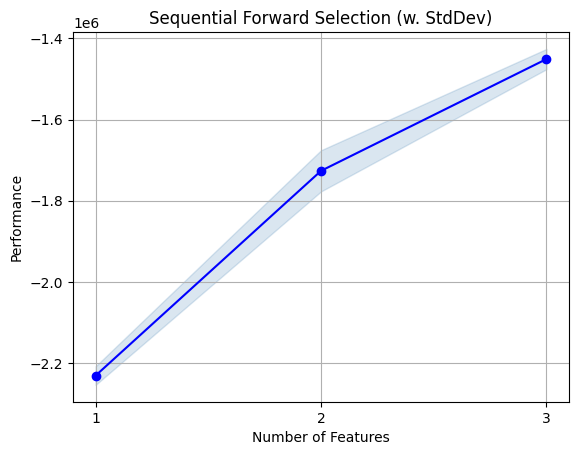

In [317]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()



In [ ]:
rfe_sfs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', regressor)
])

rfe_sfs_pipeline.fit(X_train, y_train)

In [ ]:
predictions_sfs = rfe_sfs_pipeline.predict(X_test)

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions_sfs)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions_sfs)
metrics["mse"] = mean_squared_error(y_test, predictions_sfs)

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_sfs_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')


Можно совмещать признаки, выбранные по sfs и sbs: брать их объединение или пересечение. Можно комбинировать с признаками, выделенными разными подходами - целое поле для исследований

# HYPERPARAMS
## Gridsearch

In [224]:
from sklearn.model_selection import  GridSearchCV

In [ ]:
param_grid = {
    'model__depth': [1,3,5]
}

In [ ]:
gs = GridSearchCV(rfe_sfs_pipeline, param_grid, cv=2, scoring='neg_mean_absolute_error')
gs.fit(X_train, y_train)
print("Лучшие гиперпараметры:", gs.best_params_)

In [ ]:
gs_pipeline  = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', CatBoostRegressor(depth=5))
])

# Проведем стандартную проверку на тестовом множестве и залогируем run

Вместо GridSearch можно использовать RandomSearch

## Optuna

In [292]:
import optuna

In [ ]:
def objective(trial):
    # предлагаем гиперпараметры
    depth = trial.suggest_int('depth', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)

    # создаём и обучаем модель
    opt_pipeline  = Pipeline(steps=[
        ('preprocessor', preprocessor_sklearn), 
        ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
        ('model', CatBoostRegressor(depth=depth, learning_rate=learning_rate, verbose=0))
    ])

    opt_pipeline.fit(X_train, y_train)

    # предсказываем и вычисляем RMSE
    preds = opt_pipeline.predict(X_test)
    mae =  mean_absolute_error(y_test, preds)   

    return mae

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# выводим результаты
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params) 

In [ ]:
opt_pipeline  = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', CatBoostRegressor(depth=3, learning_rate=0.02789))
])

# Проведем стандартную проверку на тестовом множестве и залогируем run

Выбираем лучшую модель.
Обучаем ее на всей выборке (а не только на train-части). 
Далее будем деплоить именно её